In [8]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from matplotlib.animation import FuncAnimation

In [9]:
from scipy.signal import savgol_filter


def compute_spread_len(ds, h_factor=1.1):
    mask = ds.h > ds.attrs["hₛ"] * h_factor
    return mask.sum("x").isel(y=0) * ds.x.diff("x").median()


def compute_drop_velocity(ds, filter_winlen=51, filter_polyorder=3):
    c = ds.x[ds.h.argmax("x").isel(y=0)].diff("t")
    c = c.where((c > 0) & (c < 20)).dropna("t").interp(t=ds.t)
    c = xr.DataArray(
        data=savgol_filter(c, filter_winlen, filter_polyorder),
        coords=c.coords,
        dims=c.dims,
    )
    return c

In [11]:
ds = xr.open_dataset("../data/outputs/reproj_test/hₛ=0.02_reproject=true.nc")
ds.t.isel(t=-1)

<xarray.DataArray 't' ()>
array(702.)
Coordinates:
    t        float64 702.0

In [12]:
ds = xr.open_dataset("../data/outputs/reprojection/hₛ=0.02_reproject=false.nc")
ds.t.isel(t=-1)

<xarray.DataArray 't' ()>
array(515.1)
Coordinates:
    t        float64 515.1

In [11]:
from pathlib import Path

datasets = {}
for ds in sorted(Path("../data/outputs/reprojection/").glob("*.nc")):
    ds = xr.open_dataset(ds)
    ds["spread_len"] = compute_spread_len(ds)
    ds["drop_velocity"] = compute_drop_velocity(ds, filter_winlen=101)
    datasets[(ds.attrs["hₛ"], ds.attrs["reproject"])] = ds
datasets = {key: datasets[key] for key in sorted(datasets, key=lambda x: x[0])}

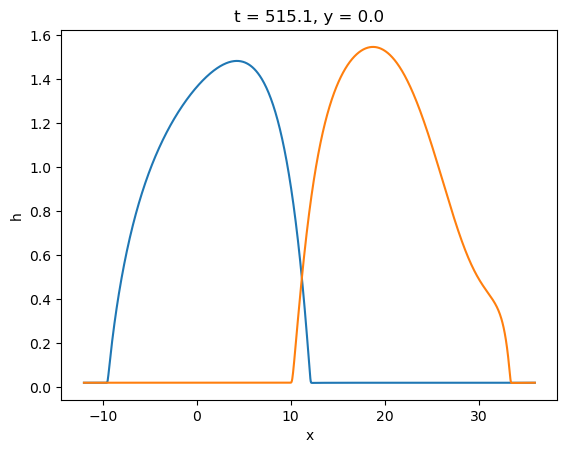

In [12]:
datasets[(0.02, True)].h.isel(t=-1).plot()
datasets[(0.02, False)].h.isel(t=-1).plot()

In [16]:
datasets.keys()

dict_keys([(0.02, 0), (0.02, 1), (0.025, 0), (0.025, 1), (0.03, 0), (0.03, 1), (0.05, 0), (0.05, 1)])

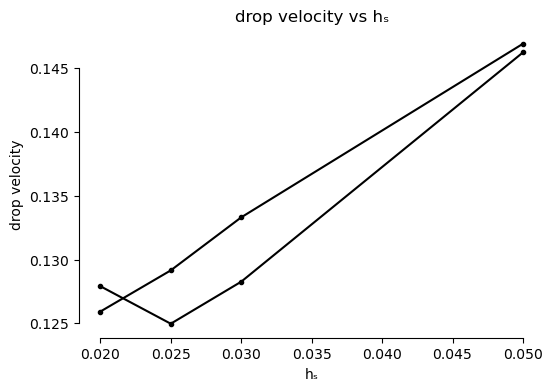

In [19]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(
    *zip(
        *[
            (hs, ds.drop_velocity.isel(t=slice(-500)).mean())
            for (hs, proj), ds in datasets.items()
            if proj
        ]
    ),
    marker=".",
    color="k",
)
ax.plot(
    *zip(
        *[
            (hs, ds.drop_velocity.isel(t=slice(-500)).mean())
            for (hs, proj), ds in datasets.items()
            if not proj
        ]
    ),
    marker=".",
    color="k",
)
ax.set_xlabel("hₛ")
ax.set_ylabel("drop velocity")
ax.set_title("drop velocity vs hₛ")
sns.despine(trim=True)


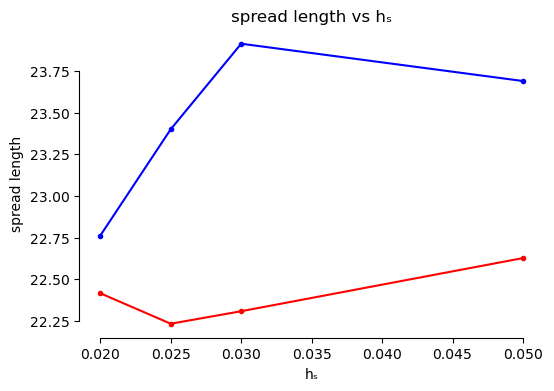

In [21]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(
    *zip(
        *[
            (hs, ds.spread_len.isel(t=slice(-500)).mean())
            for (hs, proj), ds in datasets.items()
            if proj
        ]
    ),
    marker=".",
    color="r",
)
ax.plot(
    *zip(
        *[
            (hs, ds.spread_len.isel(t=slice(-500)).mean())
            for (hs, proj), ds in datasets.items()
            if not proj
        ]
    ),
    marker=".",
    color="b",
)
ax.set_xlabel("hₛ")
ax.set_ylabel("spread length")
ax.set_title("spread length vs hₛ")
sns.despine(trim=True)


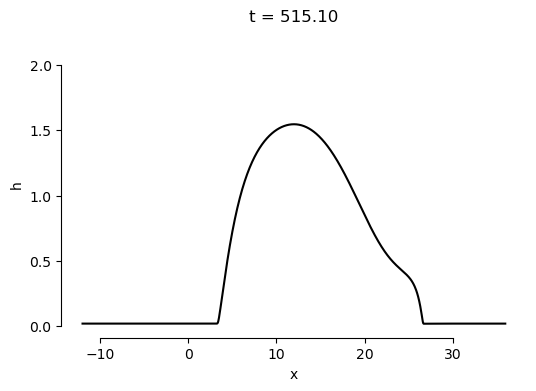

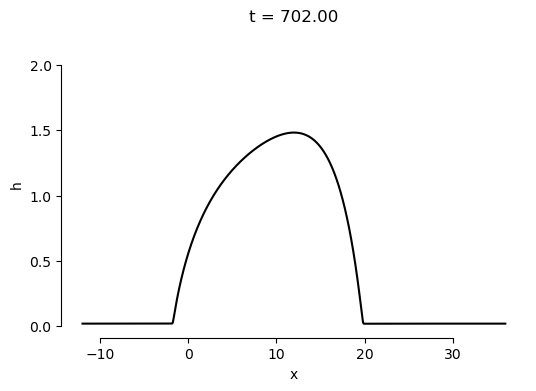

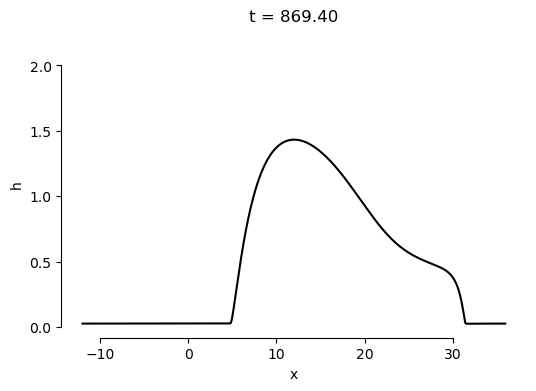

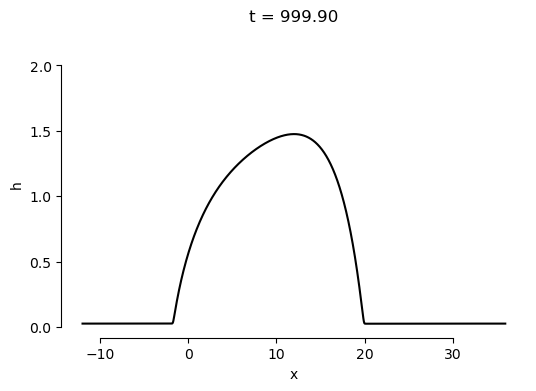

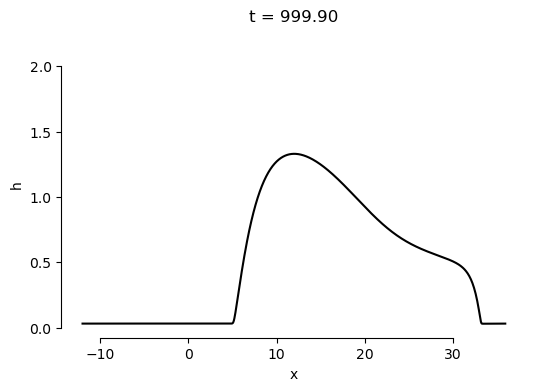

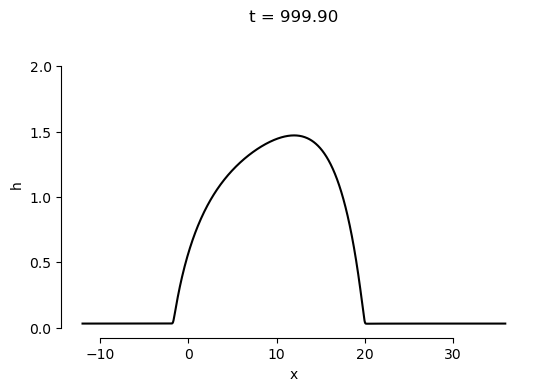

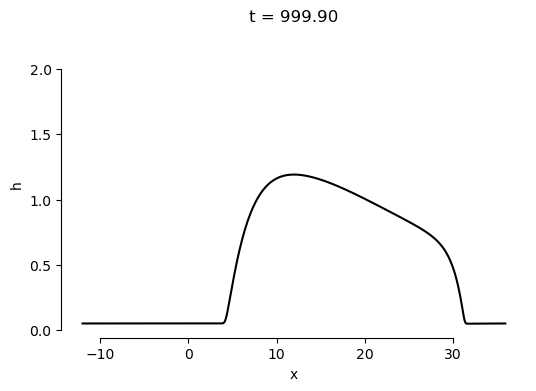

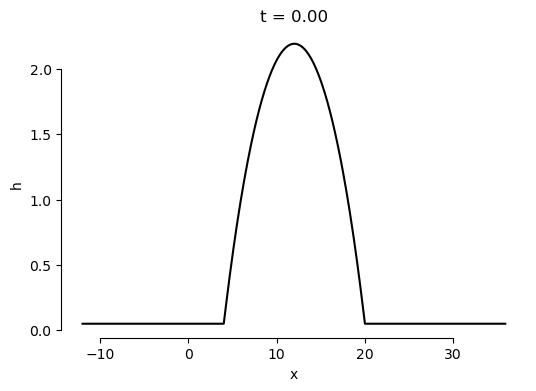

In [23]:
for (hs, proj) in datasets:
    ds = datasets[(hs, proj)].sel(y=0)

    fig, ax = plt.subplots(figsize=(6, 4))

    frame = ds.h.sel(t=0.0)
    frame = frame.roll(x=len(ds.x) // 2 - int(frame.argmax("x")))
    ax.plot(ds.x, frame, color="k")
    ax.set_title(f"t = {0.0:.2f}")
    ax.set_xlabel("x")
    ax.set_ylabel("h")
    ymin, ymax = ax.get_ylim()
    sns.despine(trim=True)
    def animate(t):
        ax.clear()
        frame = ds.h.sel(t=t)
        frame = frame.roll(x=len(ds.x) // 2 - int(frame.argmax("x")))
        ax.plot(ds.x, frame, color="k")
        ax.set_title(f"t = {t:.2f}")
        ax.set_xlabel("x")
        ax.set_ylabel("h")
        ax.set_ylim(ymin, ymax)
        sns.despine(trim=True)
        return ax

    anim = FuncAnimation(fig, animate, frames=ds.t, interval=100)
    anim.save(f"../movies/hs={hs:g}_reproject={proj}.mp4", writer="ffmpeg", fps=24)

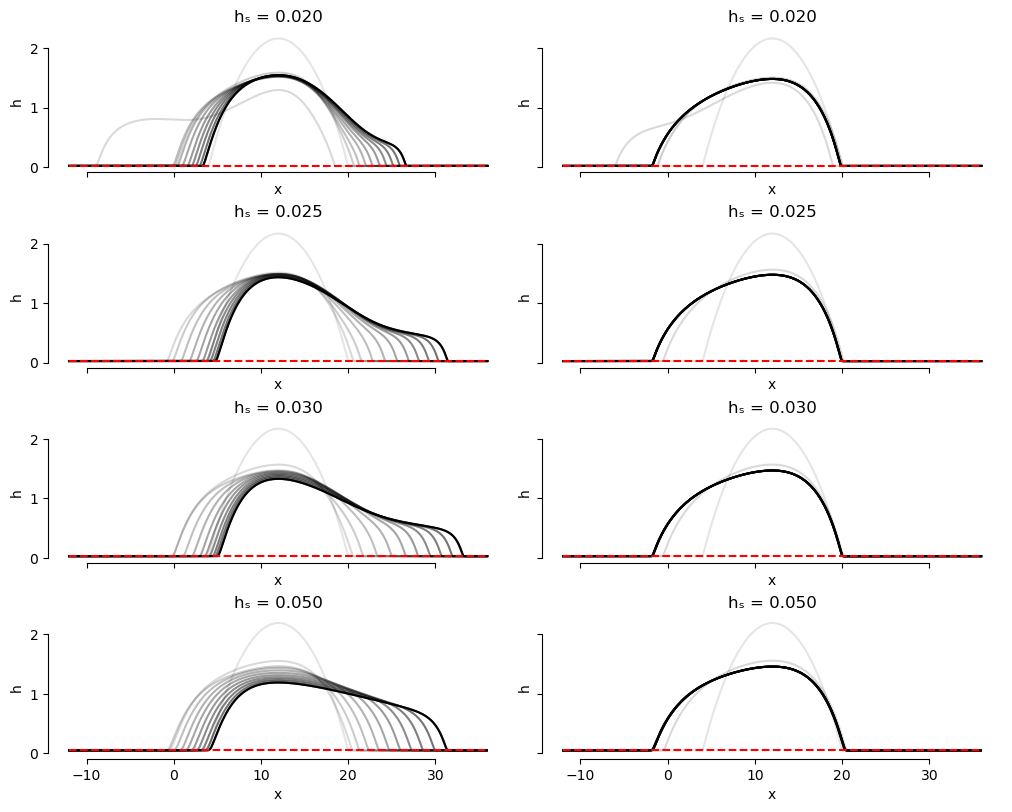

In [52]:
fig, axs = plt.subplots(4, 2, figsize=(10, 8), sharex=True, sharey=True, constrained_layout=True)

for ds, ax in zip(datasets.values(), axs.flatten()):
    xmin, xmax = ds.x.min(), ds.x.max()
    n_traces = 10
    step = len(ds.t) // n_traces
    for i, t in enumerate(ds.t[::step]):
        frame = ds.h.sel(t=t)
        frame = frame.roll(x=len(ds.x) // 2 - int(frame.argmax("x")))
        frame.plot(ax=ax, color="k", alpha=(i / n_traces) * (0.6 - 0.1) + 0.1)
    frame = ds.h.isel(t=-1)
    frame = frame.roll(x=len(ds.x) // 2 - int(frame.argmax("x")))
    frame.plot(ax=ax, color="k")
    ax.hlines(ds.attrs["hₛ"] * 1.1, xmin, xmax, color="r", linestyle="--")
    ax.set_title(f"hₛ = {ds.attrs['hₛ']:.3f}")
    sns.despine(trim=True)
fig.savefig("../reports/figures/hs_reproj/traces_x_vs_h.pdf", dpi=300)
fig.savefig("../reports/figures/hs_reproj/traces_x_vs_h.png", dpi=100)

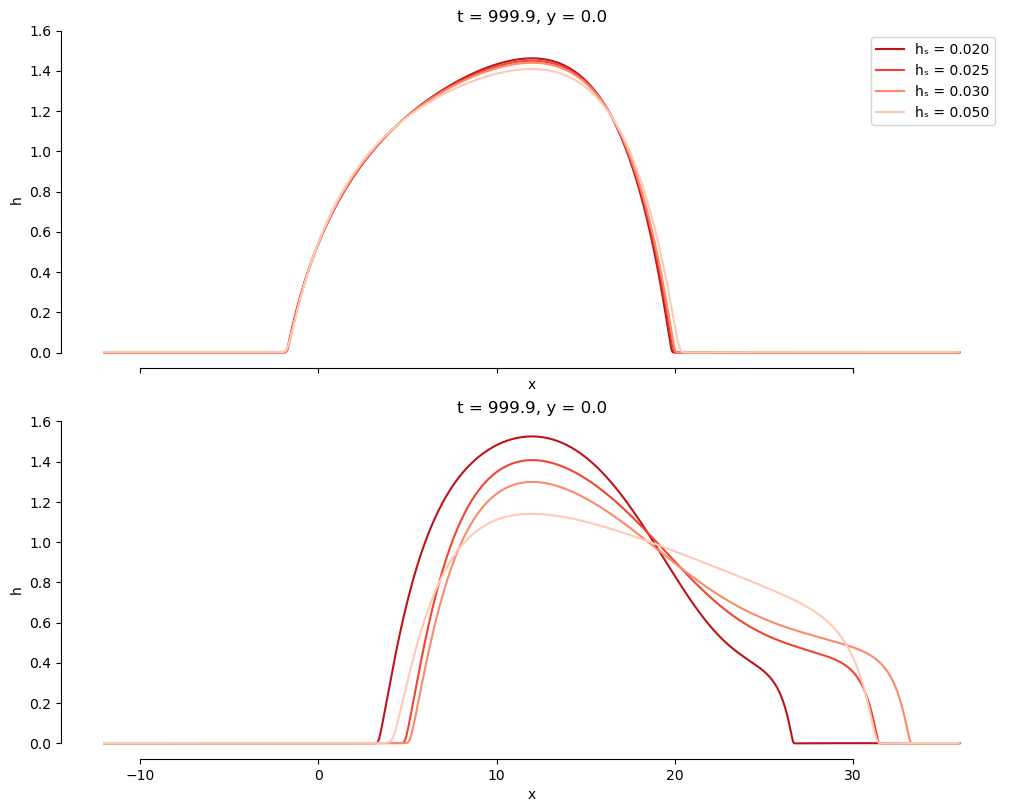

In [53]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, sharey=True, constrained_layout=True)

cycle1 = iter(sns.color_palette("Reds_r", n_colors=4).as_hex())
cycle2 = iter(sns.color_palette("Reds_r", n_colors=4).as_hex())
for ds in list(datasets.values()):
    if ds.attrs["reproject"]:
        ax = ax1
        color = next(cycle1)
    else:
        ax = ax2
        color = next(cycle2)
    frame = ds.h.isel(t=-1)
    frame = frame.roll(x=len(ds.x) // 2 - int(frame.argmax("x"))) - ds.attrs["hₛ"]
    frame.plot(ax=ax, color=color, label=f"hₛ = {ds.attrs['hₛ']:.3f}")
    sns.despine(trim=True)
ax1.legend()
fig.savefig("../reports/figures/hs_reproj/x_vs_h.png", dpi=100)
fig.savefig("../reports/figures/hs_reproj/x_vs_h.pdf", dpi=300)

In [54]:
hss = sorted(set([hs for (hs, proj) in datasets.keys()]))

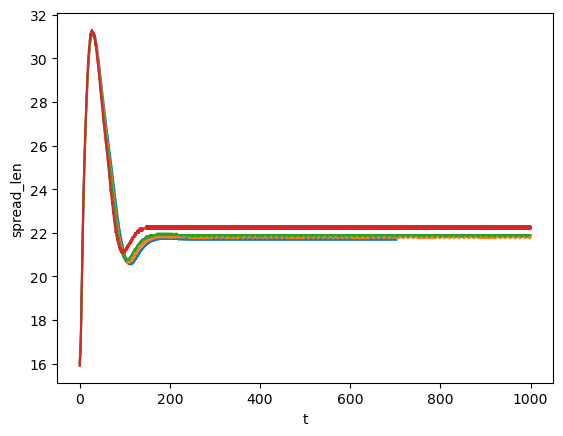

In [55]:
for hₛ in hss:
    datasets[(hs, True)].spread_len.plot()

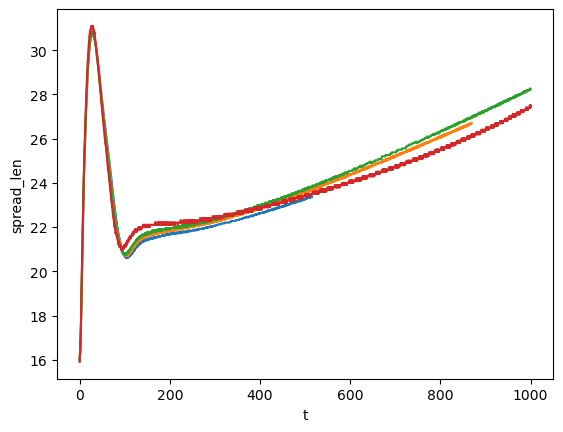

In [60]:
for hₛ in hss:
    datasets[(hs, False)].spread_len.plot()